## Runge-Kutta Method
- Implicit & Explicit iterative methods
- Similar concept to Euler's method, except modified to higher accuracy by using more terms

Let the initial value problem be:

$\frac{dy}{dx} = f(t,y_hist_hist)$ where $y(t_0) = y_0$

#### The procedure for Runge-Kutta 4 is as follows:

Pick a step size $h>0$ and define:

$y_{n+1} = y_n + \frac{h}{6}(k_1 + 2k_2 + 2k_3 + k_4)$ 

$t_{n+1} = t_n + h$

where

$k_1 = f(t_n, y_n)$,

$k_2 = f(t_n + \frac{h}{2}, y_n + h\frac{k_1}{2})$

$k_3 = f(t_n + \frac{h}{2}, y_n + h\frac{k_2}{2})$

$k_4 = f(t_n + h, y_n + hk_3)$

The $k_1, k_2, k_3, k_4$ values can be interpreted as:

1. The slope at the start, determined using Euler's method

2. The slope at the midpoint, found with slope $k_1$

3. The stope at the midpoint again, this time found with slope $k_2$

4. The slope at the endpoint, found with $k_3$

### Bicycle Model that we need to solve:
- Let $A$ be the natural system response matrix (2x2)
- Let $B$ be the control matrix
- We can formulate the overall state change matrix as $Ay + B\delta$

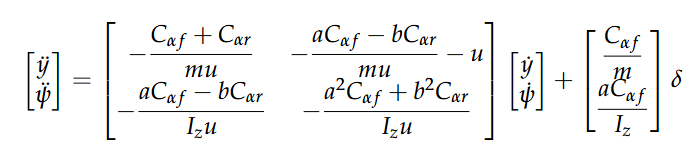

#### The Parameters we have are:

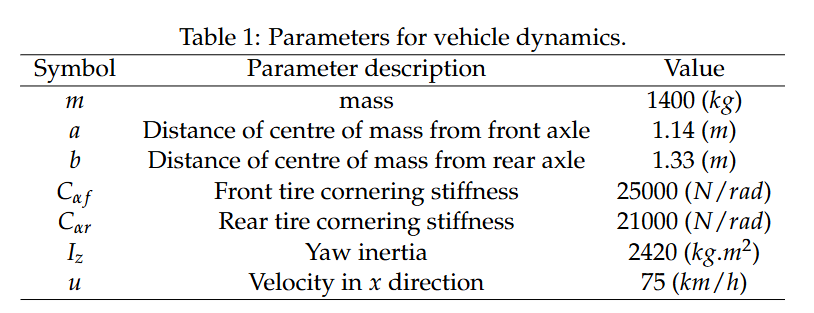

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

In [3]:
class BicycleSolver:
    def __init__(self, m, a, b, C_alpha_f, C_alpha_r, I_z, u):
        self.a = a
        self.u = u
        self.A = np.array(
            [[-1 * (C_alpha_f + C_alpha_r) / (m * u), (-1 * (a * C_alpha_f - b * C_alpha_r) / (m * u)) - u],
            [-1 * (a * C_alpha_f - b * C_alpha_r) / (I_z * u), -1 * (a**2 * C_alpha_f + b**2 * C_alpha_r) / (I_z * u)]]
        )

        self.B = np.array(
            [[C_alpha_f / m],
            [a*C_alpha_f / I_z]]
        )

        self.A_4 = np.array(
            [
                [0,0,1,0],
                [0,0,0,1],
                [0,0,-1 * (C_alpha_f + C_alpha_r) / (m * u), (-1 * (a * C_alpha_f - b * C_alpha_r) / (m * u)) - u],
                [0,0,-1 * (a * C_alpha_f - b * C_alpha_r) / (I_z * u), -1 * (a**2 * C_alpha_f + b**2 * C_alpha_r) / (I_z * u)]
            ]
        )

        self.B_4 = np.array(
            [
                [0],
                [0],
                [C_alpha_f / m],
                [a*C_alpha_f / I_z]
            ]
        )
    
    def solve(self, iterator, func, init_vector: np.ndarray, init_t, max_iter: int, step_size: float):
        """
        Generalized iterative solver that solves Y' = func using the specified iteration method.
        """
        y = init_vector.copy()
        res = []
        t = init_t
        for i in range(max_iter):
            y = iterator(func, y, t, step_size)
            t += step_size
            res.append(y)

        return y, np.array(res)
    
    def check_stability(self):
        eigenvalues = np.linalg.eig(self.A).eigenvalues
        for eigenvalue in eigenvalues:
            if eigenvalue > 0:
                return False
        
        return True
    
        
    def ground_velocity(self, y_hist: np.ndarray):
        # Extract correct values for all trials
        yaw = y_hist[:, 1] /180 * np.pi    # Shape: (trials,)
        yaw_dot = y_hist[:, 3] / 180 * np.pi # Shape: (trials,)
        y_dot = y_hist[:, 2]   # Shape: (trials,)

        # Compute velocity components
        ground_velocity = np.stack([
            self.u * np.cos(yaw) - (y_dot + self.a * yaw_dot) * np.sin(yaw),
            (y_dot + self.a * yaw_dot) * np.cos(yaw) + self.u * np.sin(yaw)
        ], axis=1)        
        
        return ground_velocity
    
    def ground_position(self, ground_velocity : np.array, time_step : float, intial_pos = [0,0]):
        ground_position = deepcopy(ground_velocity)
        ground_position[0][0] = intial_pos[0] + ground_velocity[0][0] * time_step
        ground_position[0][1] = intial_pos[1] + ground_velocity[0][1] * time_step

        for i in range(1, ground_velocity.shape[0]):
            ground_position[i][0] = ground_position[i-1][0] + ground_velocity[i][0] * time_step
            ground_position[i][1] = ground_position[i-1][1] + ground_velocity[i][1] * time_step
        
        return ground_position
    
    @staticmethod
    def eulers_method(func, y_curr: np.ndarray, t, step_size: float) -> np.ndarray:
        """
        Euler's Method for n-dimensional systems.
        
        Args:
            func: F(Y, t). (n, 1) output shape
            y_curr: Y_i. (n, 1) shaped
            step_size: delta t. Scalar

        Returns:
            y_next: Y_i+1. (n, 1) shaped
        """
        y_next = y_curr + step_size * func(y_curr, t)

        return y_next

    @staticmethod
    def rk4(func, y_curr: np.ndarray, t, step_size: float) -> np.ndarray:
        k1: np.ndarray = func(y_curr, t)

        v2: np.ndarray = y_curr + step_size / 2 * k1
        k2: np.ndarray = func(v2, t + step_size / 2)

        v3: np.ndarray = y_curr + step_size / 2 * k2
        k3: np.ndarray = func(v3, t + step_size / 2)

        v4: np.ndarray = y_curr + step_size * k3
        k4: np.ndarray = func(v4, t + step_size)

        return y_curr + step_size / 6 * (k1 + 2*k2 + 2*k3 + k4)
    
    @staticmethod
    def bicycle_model(A, B, y, delta) ->np.ndarray:
        return np.matmul(A, y) + B*delta
    
    @staticmethod
    def target(t):
        """
        Helper Function to test solver. Taken from the project manual, this computes the solution for time t
        using init [0,0] and table parameters.
        """
        return np.array(
            [[-13.0964*np.e**(-1 * 1.9745 * t) + 24.468*np.e**(-1*0.9839*t) - 11.3720],
            [-0.2496*np.e**(-1 * 1.9745 * t) - 0.69262*np.e**(-1*0.9839*t) + 0.9457]]
        )
    
    def visualize_results(self, histories, labels, init_t, t_final, max_iter, title="", titleb=""):
        plt.close('all')
        plt.figure()
        for i, hist in enumerate(histories):
            t_values = np.linspace(init_t, t_final, max_iter)
            plt.plot(t_values, [val[0] for val in hist], label=labels[i])

        # Y accel
        plt.xlabel('Time (s)')
        plt.ylabel("Y Acceleration (m/s^2)")
        plt.legend()
        plt.grid()
        plt.title(title)
        plt.show()

        plt.figure()

        # Yaw Rate
        for i, hist in enumerate(histories):
            t_values = np.linspace(init_t, t_final, max_iter)
            plt.plot(t_values, [val[1] for val in hist], label=labels[i])

        plt.xlabel('Time (s)')
        plt.ylabel("Yaw Rate (rads/s^2)")
        plt.legend()
        plt.grid()
        if titleb:
            plt.title(titleb)
        else:
            plt.title(title)
        plt.show()
    
    def visualize_results2(self, histories, labels, init_t, t_final, max_iter, title=""):
        plt.close('all')
        plt.figure()
        for i, hist in enumerate(histories):
            t_values = np.linspace(init_t, t_final, max_iter)
            plt.plot(t_values, [val[0] for val in hist], label=labels[i])   
            

        # Y accel
        plt.xlabel('t')
        plt.ylabel("y accel")
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid()
        plt.title(title)
        plt.show()
  # Yaw Rate
        for i, hist in enumerate(histories):
            t_values = np.linspace(init_t, t_final, max_iter)
            plt.plot(t_values, [val[1] for val in hist], label=labels[i])

        plt.xlabel('t')
        plt.ylabel("Yaw Rate")
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid()
        plt.title(title)
        plt.show()

    def plot_ground_coordinates(self, histories):
        # TODO: Figure out how to do this
        # Looks like its integrating the X*, Y* and state vectors over time tho
        # Pretty annoying
        pass

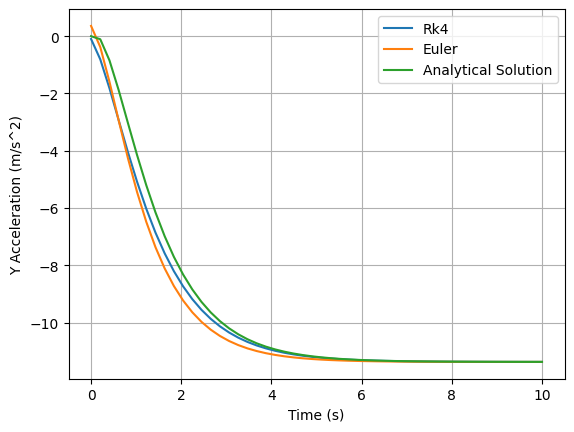

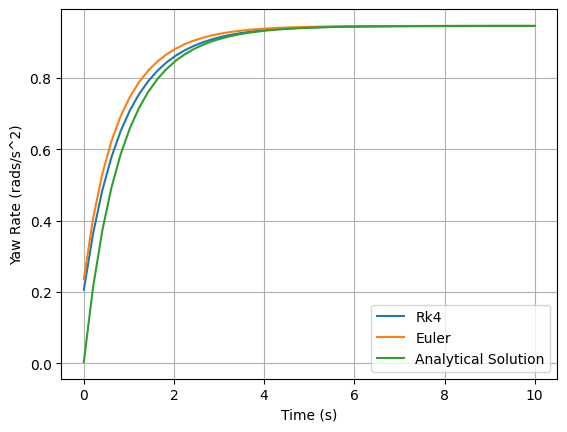

In [4]:
### Task A - Done
def const_delta(t):
    return 0.1

init_vector = np.array([[0],[0]])
t_final = 10
init_t = 0
step_size = 0.2
max_iter = int(t_final / step_size)

solver = BicycleSolver(
    m = 1400,
    a = 1.14,
    b = 1.33,
    C_alpha_f = 25000,
    C_alpha_r = 21000,
    I_z = 2420,
    u = 75 * 1000 / 3600
)

def task_a_model(y, t) -> np.ndarray:
    return solver.bicycle_model(solver.A, solver.B, y, const_delta(t))

res, hist = solver.solve(solver.rk4, task_a_model, init_vector, init_t, max_iter, step_size)
res_2, hist_2 = solver.solve(solver.eulers_method, task_a_model, init_vector, init_t, max_iter, step_size)
target_hist = [solver.target(t) for t in np.linspace(init_t, t_final, max_iter)]

solver.visualize_results([hist, hist_2, target_hist], ["Rk4", "Euler", "Analytical Solution"], init_t, t_final, max_iter)

Looks like the bicycle solver agrees with the given analytical solution :)

We still need to do grid independence check to verify that it's stable 

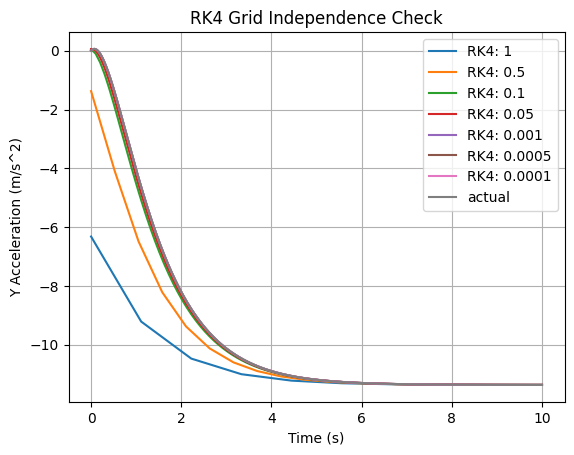

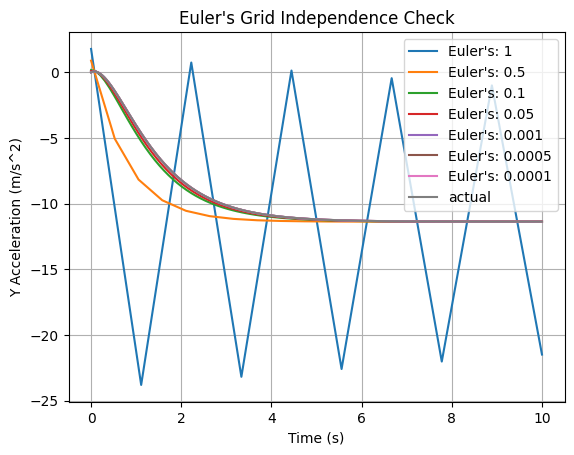

In [5]:
# Task A Q2 - Done
# Grid Independence Check
grid_values = [1, 0.5, 0.1, 0.05, 0.001, 0.0005, 0.0001]
init_vector = np.array([[0],[0]])
t_final = 10
init_t = 0

euler_results = []
rk4_results = []

solver = BicycleSolver(
    m = 1400,
    a = 1.14,
    b = 1.33,
    C_alpha_f = 25000,
    C_alpha_r = 21000,
    I_z = 2420,
    u = 75 * 1000 / 3600
)

for name, iterator in [("RK4", solver.rk4), ("Euler's", solver.eulers_method)]:
    for step_size in grid_values:
        max_iteration = int(t_final / step_size)
        _, hist_rk4 = solver.solve(iterator, task_a_model, init_vector, 0, max_iteration, step_size)

        t_values = np.linspace(init_t, t_final, max_iteration)

        plt.plot(t_values, [val[0] for val in hist_rk4], label=f"{name}: {step_size}")

    t_values = np.linspace(init_t, t_final, int(t_final / grid_values[-1]))
    plt.plot(t_values, [solver.target(t)[0] for t in t_values], label="actual")

    plt.xlabel('Time (s)')
    plt.ylabel("Y Acceleration (m/s^2)")
    plt.title(f"{name} Grid Independence Check")
    plt.legend()
    plt.grid()
    plt.show()

Only unstable looking solution is Euler's at grid spacing = 1, which isn't too alarming since:
1. 1 spacing is pretty large
2. Euler's is a very simple method, so Rk4 should always be more accurate

### Task B: Highest Stable Speeds

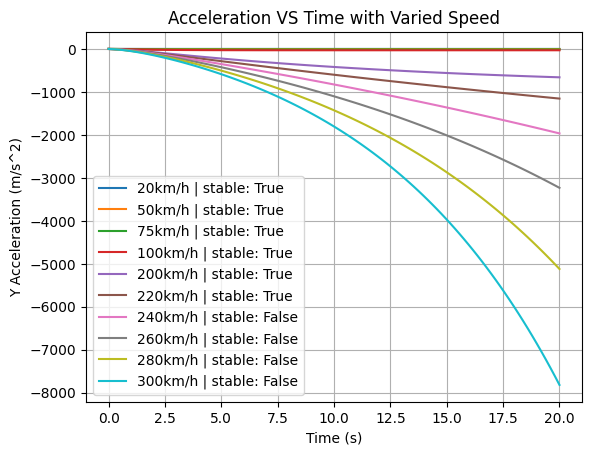

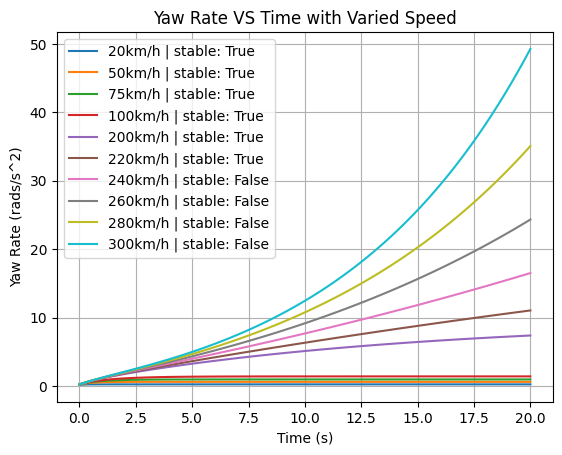

In [6]:
# We want to simulate a range of u values here - Done
# u_values_km = np.linspace(220, 240, 20)  # km
u_values_km = np.array([20, 50, 75, 100, 200, 220,240,260,280,300])
u_values = [u * 1000 / 3600 for u in u_values_km]

init_vector = np.array([[0],[0]])
t_final = 20
init_t = 0
step_size = 0.2
max_iter = int(t_final / step_size)

histories = []
labels = []

for u in u_values:
    solver = BicycleSolver(
        m = 1400,
        a = 1.14,
        b = 1.33,
        C_alpha_f = 25000,
        C_alpha_r = 21000,
        I_z = 2420,
        u = u
    )

    res, hist = solver.solve(solver.rk4, task_a_model, init_vector, init_t, max_iter, step_size)

    histories.append(hist)
    stable = solver.check_stability()
    labels.append(f'{str(round(u *3.6))}km/h | stable: {stable}')

solver.visualize_results(histories, labels, init_t, t_final, max_iter, title="Acceleration VS Time with Varied Speed", titleb="Yaw Rate VS Time with Varied Speed")

In [ ]:
### Task B2 - Done
# We can check stability by checking that graph asymptotes instead of diverging,
# i.e. difference between subsequent time steps decreases
for i, history in enumerate(histories):
    y_difference = [history[i][0] - history[i-1][0] for i in range(1, len(history))]
    yaw_difference = [history[i][1] - history[i-1][1] for i in range(1, len(history))]

    if (abs(y_difference[-1]) > abs(y_difference[-5]) or
        abs(yaw_difference[-1]) > abs(yaw_difference[-5])):
        print(f'{u_values_km[i]} diverges')

        if i > 0:
            print(f'{u_values_km[i-1]} converges')
        break


240 diverges
220 converges


Looks like its at ~227.3km/h divergence happens

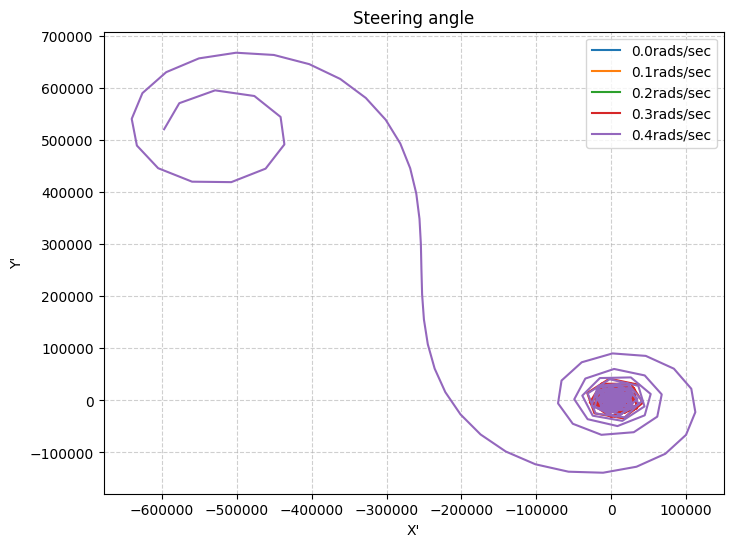

In [ ]:
### Task B3
"""
Combine the kinematics of X' and Y' and plot the track of the car for the step steering 
experiments. This is the most basic and important experiment for evaluating the handling 
of a car(see, for example, SAE Standard J266 [6]). 

"""
init_vector = np.array([[0],[0],[0],[0]])

init_t = 0
t_final = 100

step_size = .1
max_iter = int(t_final / step_size)

plt.figure(figsize=(8, 6))

steering_angles = [value * 0.1 for value in range(5)]

for steering_angle in steering_angles:
    solver = BicycleSolver(
        m = 1400,
        a = 1.14,
        b = 1.33,
        C_alpha_f = 25000,
        C_alpha_r = 21000,
        I_z = 2420,
        u = 250 * 1000 / 3600
    )

    def task_a_model(y, t) -> np.ndarray:
        return solver.bicycle_model(solver.A_4, solver.B_4, y, steering_angle)

    res, hist = solver.solve(solver.rk4, task_a_model, init_vector, init_t, max_iter, step_size)
    ground_velocity = solver.ground_velocity(hist)
    ground_position = solver.ground_position(ground_velocity,step_size)
    plt.plot(ground_position[:,0], ground_position[:,1], label=f"{round(steering_angle, 2)}rads/sec")

    # res_2, hist_2 = solver.solve(solver.eulers_method, task_a_model, init_vector, init_t, max_iter, step_size)
    # ground_velocity_2 = solver.ground_velocity(hist_2)
    # ground_position_2 = solver.ground_position(ground_velocity,step_size)
    # plt.plot(ground_position[:,0], ground_position[:,1], label=f"{round(steering_angle* 0.1, 1)}rads/sec")

plt.xlabel("X'")
plt.ylabel("Y'")
plt.title("Steering angle")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

(a) Is this car oversteering or understeering at speed of 100 km/h? 

### Task C: What if you have something in the trunk

Something heavy in the trunk / hood means:
- Total mass changes
- CoG changes, so a & b distances also change

In [ ]:
# Placement loc (0) for rear wheel, (1) for front - Dnoe
def get_new_m_a_b(m, a, b, added_w, placement_loc):
    new_m = m + added_w

    # car could be split into 2 point masses at
    # front & rear tires. So the new CoG is just the weighted
    # avg of the new rear & front weights
    front_mass = m / 2 + added_w * placement_loc
    rear_mass = m / 2 + added_w * 1 - placement_loc

    # Fix the coords system @ b = 0
    total = a + b
    frac = rear_mass / new_m
    new_b = total * frac
    new_a = total - new_b

    return new_m, new_a, new_b

In [ ]:
# Try putting 10kg on the back wheel of a 10kg car
get_new_m_a_b(10, 1, 1, 10, 0)

(20, 0.5, 1.5)

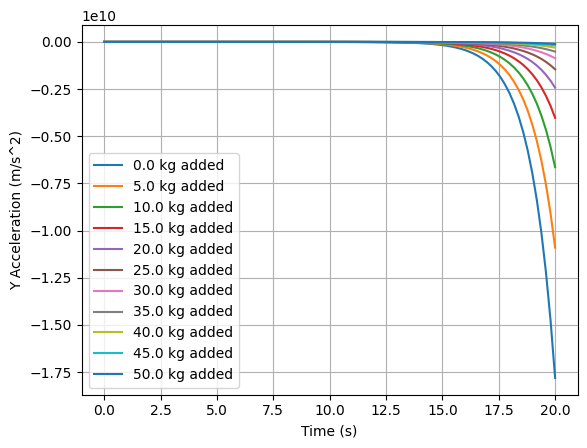

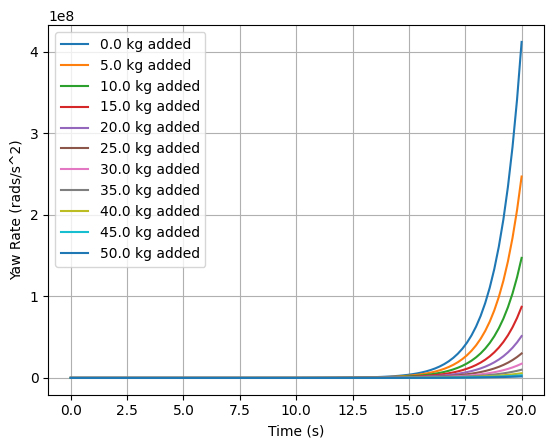

In [ ]:
added_w = np.linspace(0, 50, 11)
cog_values = [get_new_m_a_b(1400, 1.14, 1.33, w, 0) for w in added_w]

u = 227 * 1000 / 3600
init_vector = np.array([[0],[0],[0],[0]])
t_final = 20
init_t = 0
step_size = 0.2
max_iter = int(t_final / step_size)

histories = []
labels = []

for i, (m, a, b) in enumerate(cog_values):
    solver = BicycleSolver(
        m = m,
        a = a,
        b = b,
        C_alpha_f = 25000,
        C_alpha_r = 21000,
        I_z = 2420,
        u = u
    )

    res, hist = solver.solve(solver.rk4, task_a_model, init_vector, init_t, max_iter, step_size)

    histories.append(hist)
    labels.append(f'{round(added_w[i],2)} kg added')

solver.visualize_results(histories, labels, init_t, t_final, max_iter)



In [ ]:
#Carmelli's Wack Ass Shit Code
u_values_km = np.array([20, 50, 75, 100, 200, 220,240,260,280,300])
u_values = [u * 1000 / 3600 for u in u_values_km]

added_w = np.linspace(0, 50, 11)
cog_values = [get_new_m_a_b(1400, 1.14, 1.33, w, 0) for w in added_w]

u = 227 * 1000 / 3600
init_vector = np.array([[0],[0]])
t_final = 20
init_t = 0
step_size = 0.2
max_iter = int(t_final / step_size)

histories = []
labels = []

for i, (m, a, b) in enumerate(cog_values):
    for u in u_values:
        solver = BicycleSolver(
            m = m,
            a = a,
            b = b,
            C_alpha_f = 25000,
            C_alpha_r = 21000,
            I_z = 2420,
            u = u
    )

    res, hist = solver.solve(solver.rk4, task_a_model, init_vector, init_t, max_iter, step_size)

    histories.append(hist)
    labels.append(f'{round(added_w[i],2)} kg added')

solver.visualize_results(histories, labels, init_t, t_final, max_iter)

            # Check for divergence (e.g., if any value in the history exceeds a threshold)
if np.any(np.abs(hist) > 1e6):  # Adjust threshold as needed
    diverged_at_speed = u * 3.6  # Convert speed back to km/h 
      # Stop testing higher speeds for this weight

    # Record the divergence speed for this mass
# if diverged_at_speed is not None:
#         divergence_speeds.append((added_w[i], diverged_at_speed))
#     else:
#         divergence_speeds.append((added_w[i], None))  # No divergence detected

# # Output the results
# for mass, speed in divergence_speeds:
#     if speed is not None:
#         print(f"With {round(mass, 2)} kg added, the car diverges at {round(speed, 2)} km/h")
#     else:
#         print(f"With {round(mass, 2)} kg added, the car does not diverge within the tested speed range.")

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2 is different from 4)

In [ ]:
for i, history in enumerate(histories):
    y_difference = [history[i][0] - history[i-1][0] for i in range(1, len(history))]
    yaw_difference = [history[i][1] - history[i-1][1] for i in range(1, len(history))]

    if (abs(y_difference[-1]) > abs(y_difference[-5]) or
        abs(yaw_difference[-1]) > abs(yaw_difference[-5])):
        print(f'{u_values_km[i]} diverges')

        if i > 0:
            print(f'{u_values_km[i-1]} converges')
        break


20 diverges


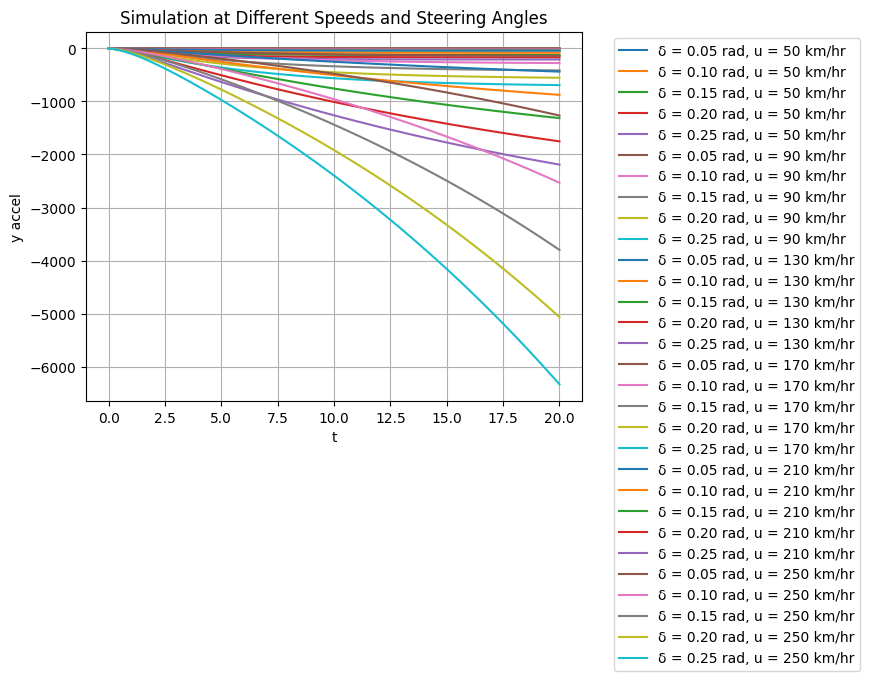

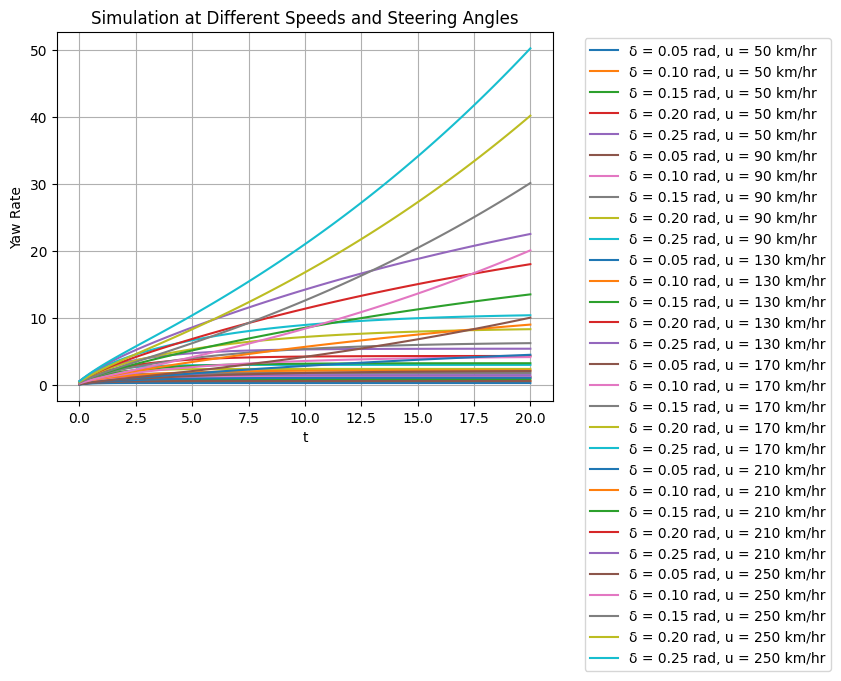

In [ ]:
### Task C2

# Convert speed from km/h to m/s
u_values_km = np.linspace(50, 250, 6)  # km/h
u_values = [u * 1000 / 3600 for u in u_values_km]  # m/s

init_vector = np.array([[0],[0]])
t_final = 20
init_t = 0
step_size = 0.2
max_iter = int(t_final / step_size)

#iterate through delta
delta = [0.05, 0.1, 0.15, 0.2, 0.25]


histories = []
labels = []

# Simulate car behavior for different steering angles
for u in u_values:
    for delta_value in delta:
        solver = BicycleSolver(
            m=1400, 
            a=1.14,  
            b=1.33,  
            C_alpha_f=25000,  
            C_alpha_r=21000,  
            I_z = 2420,
            u=u  
        )

        def task_a_model(y,t) -> np.ndarray:
            return solver.bicycle_model(solver.A, solver.B, y, delta_value)

        res, hist = solver.solve(solver.rk4, task_a_model, init_vector, init_t, max_iter, step_size)
    

        histories.append(hist)
        labels.append(f'δ = {delta_value:.2f} rad, u = {u * 3600 / 1000:.0f} km/hr')




solver.visualize_results2(histories, labels, init_t, t_final, max_iter, title="Simulation at Different Speeds and Steering Angles")


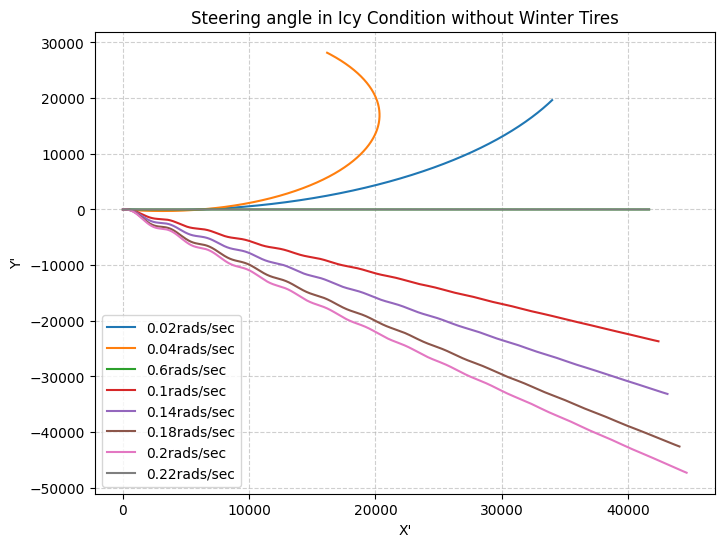

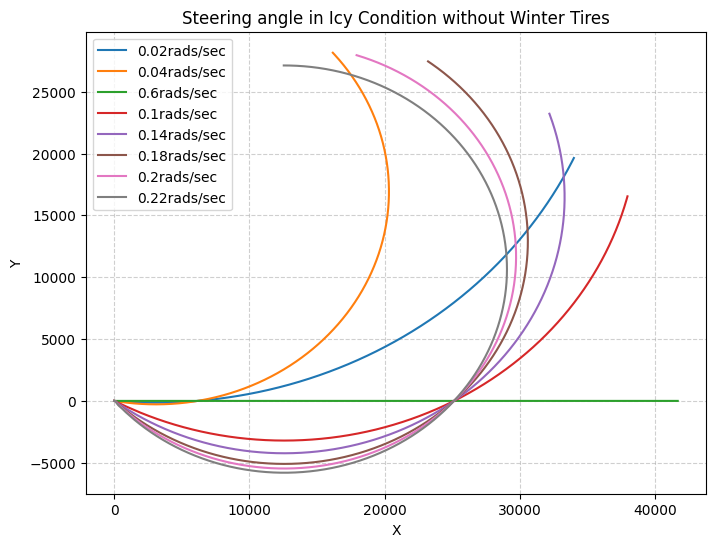

In [ ]:
###C3 - A.1 ICY CONDITIONS
# Piecewise condition to model icy road 
def summer_tires(delta : float):
    if delta <= 0.06:
        return 20000
    elif delta > 0.2:
        return 0
    else:
        return 100
    
def winter_tires(delta):
    if delta <= 0.06:
        return 20000
    elif 0.06 < delta <= 0.3:
        return 5000
    else:
        return 0
    
init_vector = np.array([[0],[0],[0],[0]])
steering_angles = [0.02, 0.04, 0.6, 0.1, 0.14, 0.18, 0.2, 0.22]

init_t = 0
t_final = 1000

step_size = 0.1
max_iter = int(t_final / step_size)

plt.figure(figsize=(8, 6))
for steering_angle in steering_angles:
    solver = BicycleSolver(
        m = 1400,
        a = 1.14,
        b = 1.33,
        C_alpha_f = summer_tires(steering_angle),
        C_alpha_r = summer_tires(steering_angle),
        I_z = 2420,
        u = 150 * 1000 / 3600
    )

    def task_a_model(y, t) -> np.ndarray:
        return solver.bicycle_model(solver.A_4, solver.B_4, y, steering_angle)

    res, hist = solver.solve(solver.rk4, task_a_model, init_vector, init_t, max_iter, step_size)
    ground_velocity = solver.ground_velocity(hist)
    ground_position = solver.ground_position(ground_velocity,step_size)
    plt.plot(ground_position[:,0], ground_position[:,1], label=f"{steering_angle}rads/sec")

plt.xlabel("X'")
plt.ylabel("Y'")
plt.title("Steering angle in Icy Condition without Winter Tires")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
for steering_angle in steering_angles:
    solver = BicycleSolver(
        m = 1400,
        a = 1.14,
        b = 1.33,
        C_alpha_f = winter_tires(steering_angle),
        C_alpha_r = winter_tires(steering_angle),
        I_z = 2420,
        u = 150 * 1000 / 3600
    )

    def task_a_model(y, t) -> np.ndarray:
        return solver.bicycle_model(solver.A_4, solver.B_4, y, steering_angle)

    res, hist = solver.solve(solver.rk4, task_a_model, init_vector, init_t, max_iter, step_size)
    ground_velocity = solver.ground_velocity(hist)
    ground_position = solver.ground_position(ground_velocity,step_size)
    plt.plot(ground_position[:,0], ground_position[:,1], label=f"{steering_angle}rads/sec")

plt.xlabel("X")
plt.ylabel("Y")
plt.title("Steering angle in Icy Condition without Winter Tires")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

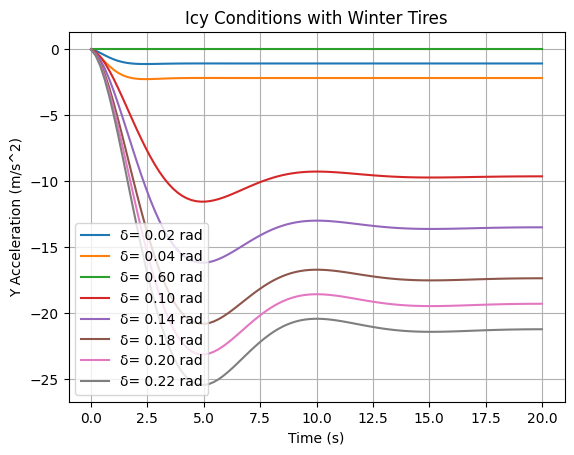

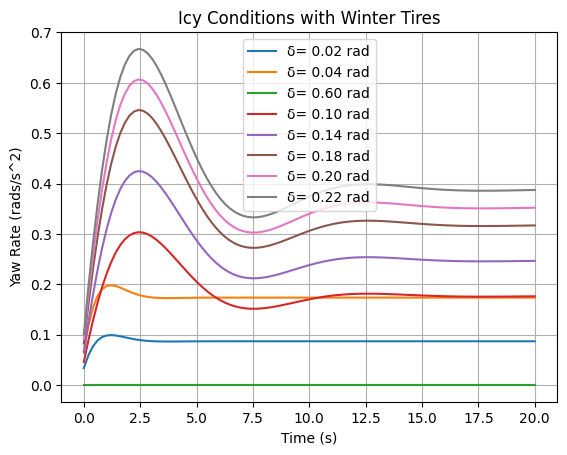

In [ ]:
###C3 - A.2 WINTER TIRES

init_vector = np.array([[0],[0]])
t_final = 20
init_t = 0
step_size = 0.2
max_iter = int(t_final / step_size) 

delta = [0.02, 0.04, 0.6, 0.1, 0.14, 0.18, 0.2, 0.22]

#piecewise condition to model icy road 
def winter_tires(delta):
    if delta <= 0.06:
        return 20000
    elif 0.06 < delta <= 0.3:
        return 5000
    else:
        return 0
    
histories = []
labels = []

# Simulate car behavior for different steering angles
for i, delta_value in enumerate(delta):
    solver = BicycleSolver(
        m=1400, 
        a=1.14,  
        b=1.33,  
        C_alpha_f = winter_tires(delta_value),
        C_alpha_r = winter_tires(delta_value),
        I_z = 2420,
        u = 75 * 1000 / 3600 
    )

    def task_a_model(y,t) -> np.ndarray:
        return solver.bicycle_model(solver.A, solver.B, y, delta_value)

    res, hist = solver.solve(solver.rk4, task_a_model, init_vector, init_t, max_iter, step_size)


    histories.append(hist)
    labels.append(f'δ= {delta_value:.2f} rad')


solver.visualize_results(histories, labels, init_t, t_final, max_iter, title= "Icy Conditions with Winter Tires")
